In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener
import math
import scipy


/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [43]:
# data_file = 'val_err_wo_lr_decay.json'
data_file = 'val_err.json'
with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 1e-5
patience = 8
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

<IPython.core.display.Javascript object>


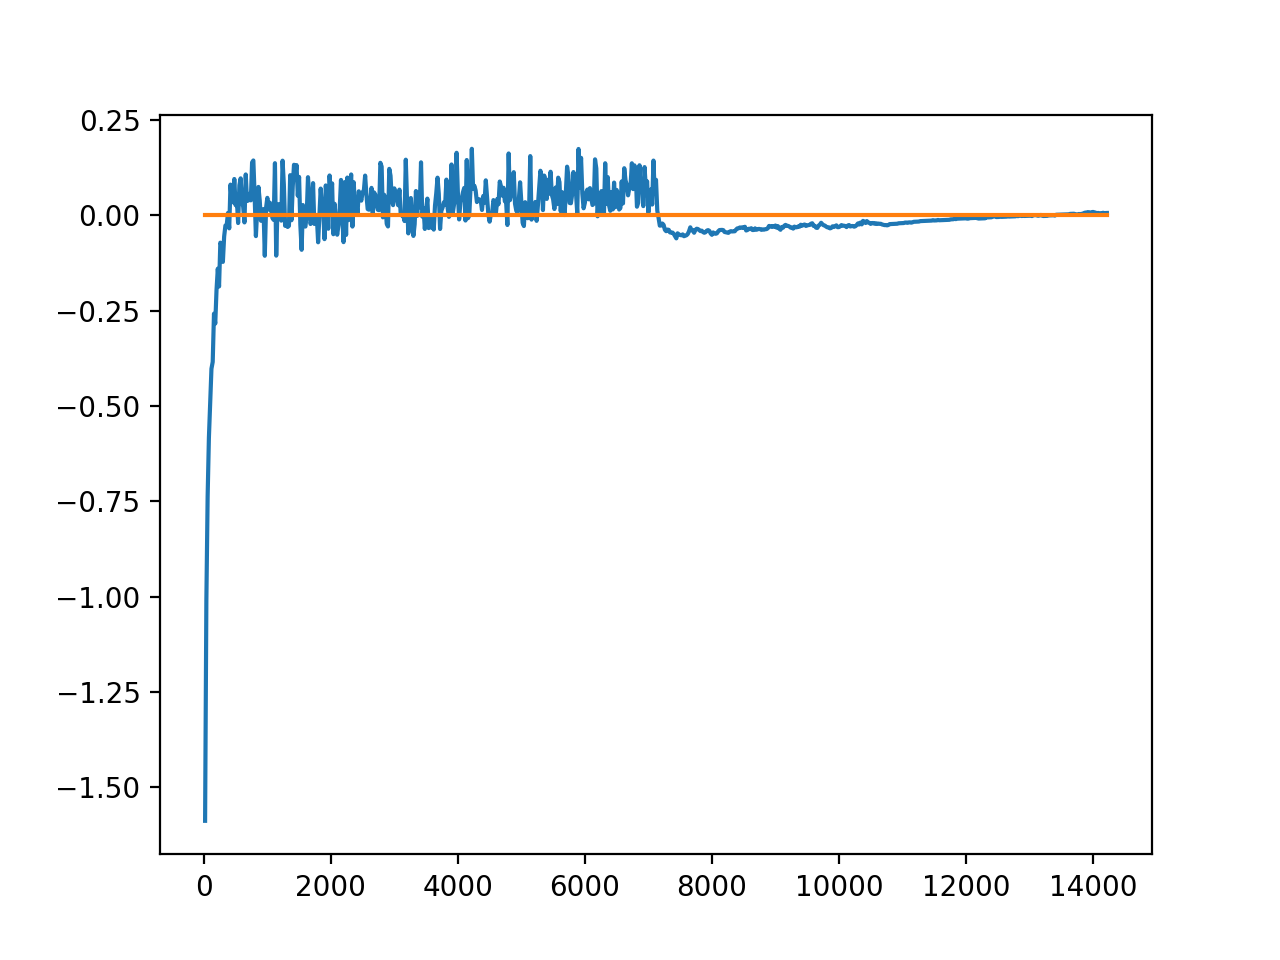

In [44]:
plt.figure()

whole_a, whole_b = power_regression(steps, val_err, np.ones(len(steps)))
ax = plt.subplot()
ax.plot(steps, val_err-whole_a*np.power(steps,whole_b))
ax.plot(steps, np.zeros(len(steps)))

<IPython.core.display.Javascript object>


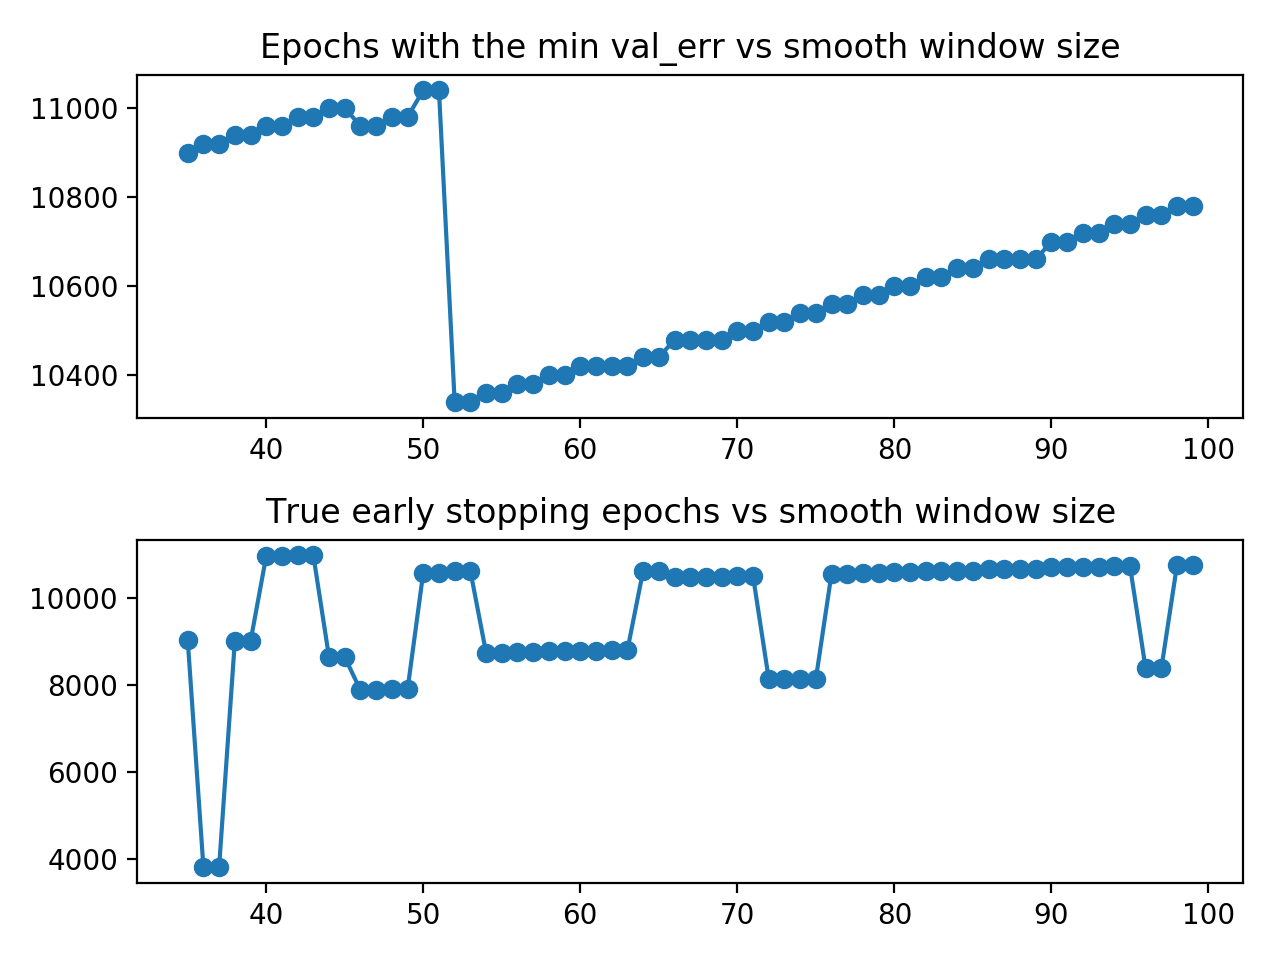

In [45]:
minEpochs = []
earlyStoppingSteps = []
x = range(35,100)
for i in x:
    smoothed_val_err_ = smooth_by_linear_filter(val_err, i)
#     print(smoothed_val_err_)
    minEpochs.append((np.argmin(smoothed_val_err_)+1)*20)
    earlyStoppingSteps.append(early_stopping_step(val_err, min_delta, patience, i, num_epochs_between_eval))


fig = plt.figure()
ax = plt.subplot(212)
ax.plot(x, earlyStoppingSteps, '-o')
ax.set_title('True early stopping epochs vs smooth window size')

ax = plt.subplot(211)
ax.plot(x, minEpochs, '-o')
ax.set_title('Epochs with the min val_err vs smooth window size')

fig.tight_layout()

In [46]:
smooth_win_size = 50
smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)

minEpoch = (np.argmin(smoothed_val_err)+1)*20
print(minEpoch, np.min(smoothed_val_err), len(smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, smoothed_val_err[earlyStoppingStep//20+1])

weights = np.ones(len(smoothed_val_err))
predictedEarlyStoppingStep, a, b = early_stopping_prediction(steps[:len(smoothed_val_err)], smoothed_val_err, min_delta, patience, weights=weights)

print(predictedEarlyStoppingStep)

11040 0.2159607819482392 686
10580 0.21607843333599616
83166.0


<IPython.core.display.Javascript object>


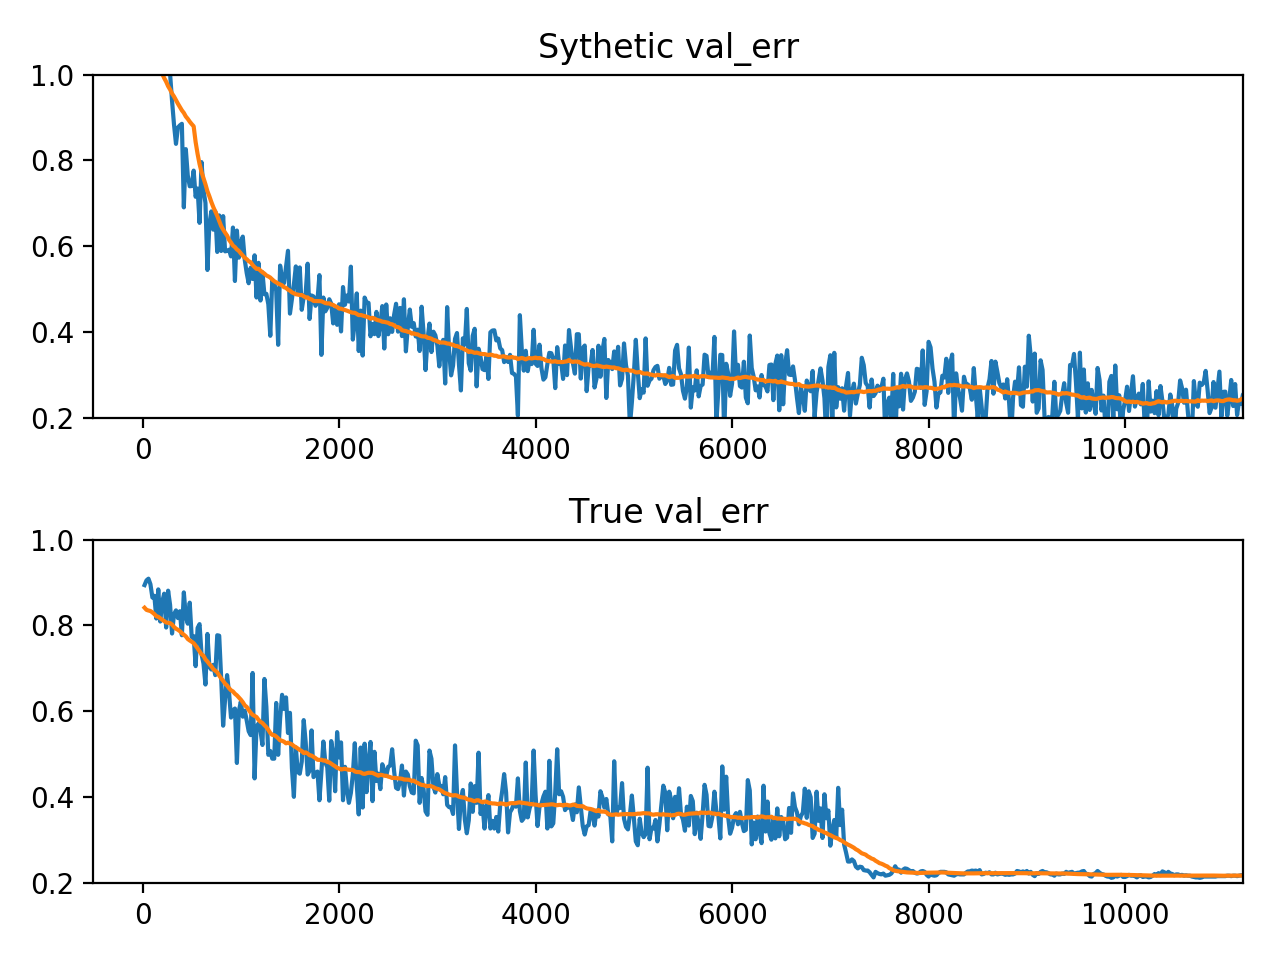

7.488320802039123 -0.37116638724395934 0.002154708308592978 1e-05 8 20 50 1000 200000.0


<IPython.core.display.Javascript object>


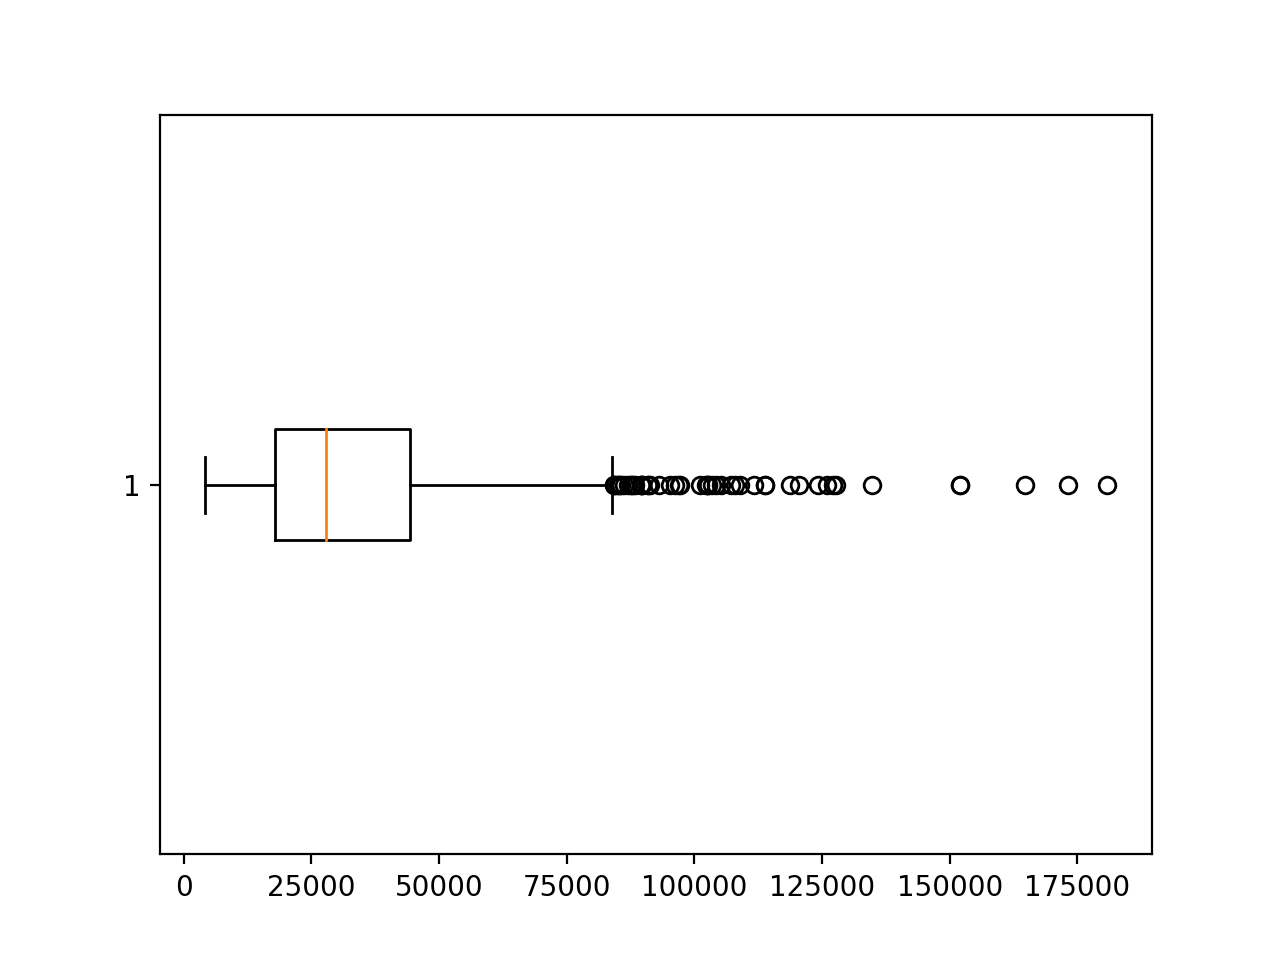

<IPython.core.display.Javascript object>


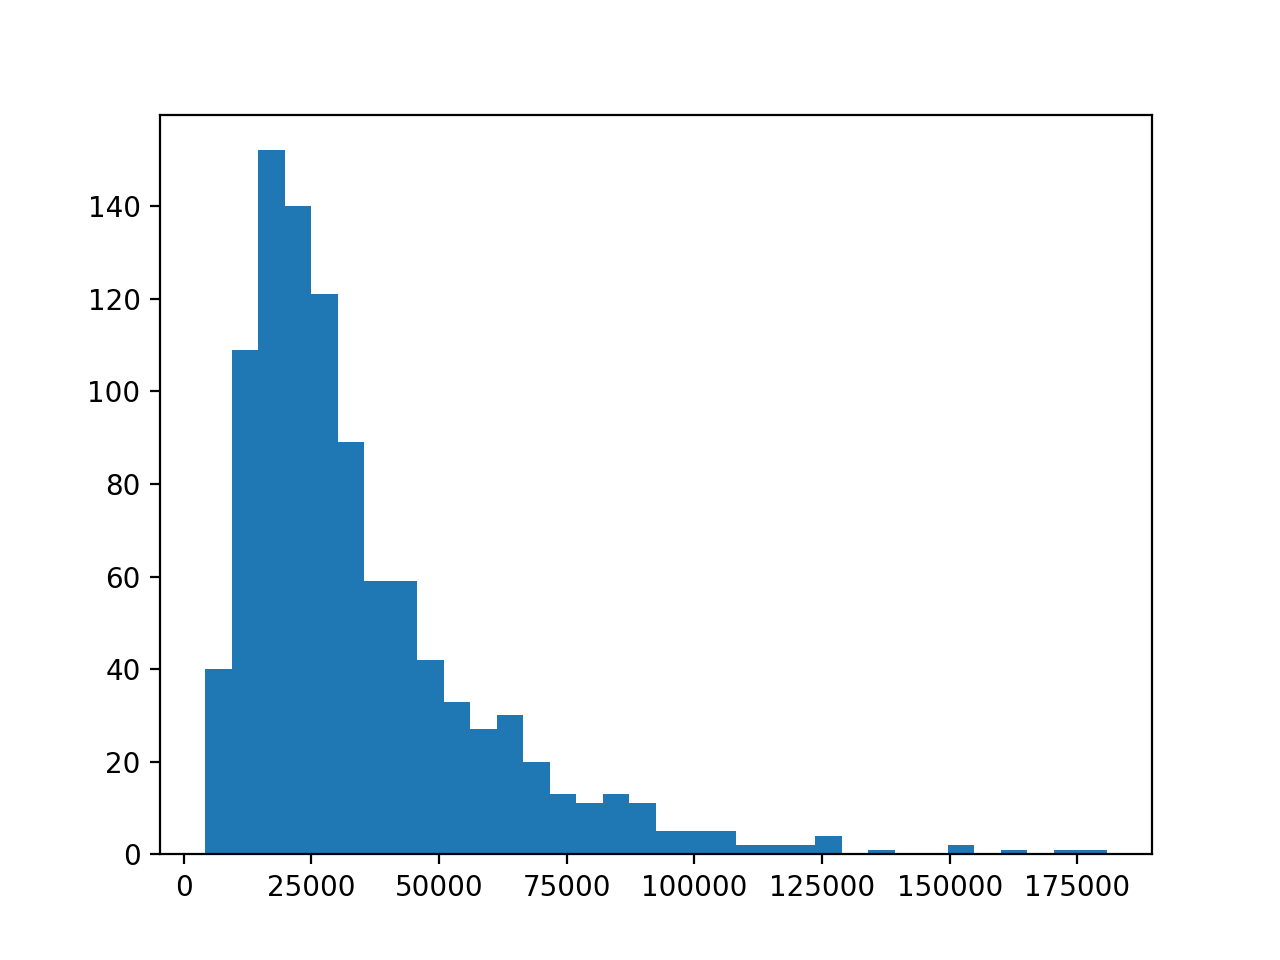

mean predicted stopping step: 34715.98
CI: (33206.487379529055,36225.47262047095)


In [47]:
"""
Predict the early stopping epoch by "adding-noise" method
input: 
    a, b: y = ax^b
    var: the variance of unsmoothed data
    min_delta, patience: no improvement (less than min_delta) for patience epoch is stopping criteria
    smooth_win_size: the window size for smoothing
    num_samples: how many samples to generate when using bootstrapping
    upper_limit: only consider the predicted epoch smaller than upper_limit
    lower_limit: only consider the predicted epoch larger than upper_limit
return:
    mean: mean of all predicted epochs
    stopping_epochs: all predicted epochs
    sample: one of the sythetic data
    smoothed_sample: smoothing the sythetic data
"""
def early_stopping_prediction_adding_noise(a,b,var,min_delta,patience, 
                                           num_epochs_between_eval,
                                           smooth_win_size,
                                           num_samples=100,
                                           upper_limit=2e4,
                                        lower_limit=0
                                          ):
    num_points = int((upper_limit-lower_limit) // num_epochs_between_eval) # the number of noisy points we want to generate
    
    x = np.arange(1,num_points+1)*num_epochs_between_eval
    y = a*np.power(x,b)
        
    stopping_epochs = [] 
    for i in range(num_samples):
        noise = np.random.normal(0, np.sqrt(var), num_points)
        z = y + noise
        
        if i == 0:
            sample = z
            smoothed_sample = smooth_by_linear_filter(z, smooth_win_size)
        
        try:
            stopping_epochs.append(
                early_stopping_step(z, min_delta, patience, smooth_win_size, num_epochs_between_eval))
        except:
            continue
    
    return np.mean(stopping_epochs), np.array(stopping_epochs), sample, smoothed_sample

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
        
    
## deviation from mean (regard the regression line as mean)
var_calculate_start_index = 100
dev = (val_err-whole_a*np.power(steps[:len(val_err)],whole_b))[var_calculate_start_index:]
var = np.var(dev)

dev_smoothed = (smoothed_val_err-a*np.power(steps[:len(smoothed_val_err)],b))[var_calculate_start_index:]
var_smoothed = np.var(dev_smoothed)

# print(var, var_smoothed)

## predict stopping epoch by bootstrapping
fig = plt.figure()
# upper_limit = len(val_err)*num_epochs_between_eval
upper_limit = 2e5

print(a,b,var,min_delta,patience,num_epochs_between_eval,smooth_win_size,1000,upper_limit)

predictedEpochWithNoise, stopping_epochs, sample, smoothed_sample \
                        = early_stopping_prediction_adding_noise(whole_a,whole_b,var,min_delta,patience,
                                                                 num_epochs_between_eval,
                                                                 smooth_win_size,
                                                                 num_samples=1000,
                                                                 upper_limit=upper_limit,
                                                                )

ax = plt.subplot(211)
x = np.arange(1,len(sample)+1)*num_epochs_between_eval
ax.plot(x,sample)
ax.plot(x[:len(smoothed_sample)],smoothed_sample)
ax.set_xlim(-500,11200)
ax.set_ylim(0.2,1)
ax.set_title("Sythetic val_err")

ax = plt.subplot(212)
ax.plot(steps, val_err)
ax.plot(steps[:len(smoothed_val_err)], smoothed_val_err)
ax.set_xlim(-500,11200)
ax.set_ylim(0.2,1)
ax.set_title("True val_err")

fig.tight_layout()

# boxplot
plt.figure()
plt.boxplot(stopping_epochs, vert=False)

# histogram
plt.figure()
plt.hist(stopping_epochs, bins='auto')

## CI
_, CI_left, CI_right = mean_confidence_interval(stopping_epochs)

print("mean predicted stopping step: {}".format(predictedEpochWithNoise))
print("CI: ({},{})".format(CI_left, CI_right))

400
1.0501224937079732 -0.04193041363589855 0.0008050119699219961 1e-05 8 20 50 1000 15820
800
1.2334553711248337 -0.07545859751976526 0.0020999815173118525 1e-05 8 20 50 1000 15820
1200
1.8145884049650698 -0.15079210796030773 0.006488019431949475 1e-05 8 20 50 1000 15820
1600
2.1719125237403474 -0.18379435506630623 0.007842612157651639 1e-05 8 20 50 1000 15820
2000
2.5357637001296633 -0.21120658683661342 0.008565764249808904 1e-05 8 20 50 1000 15820
2400
2.8290541914416663 -0.23001377394288133 0.00894870473638442 1e-05 8 20 50 1000 15820
2800
2.8878687616498744 -0.23346425465130669 0.00806469769504095 1e-05 8 20 50 1000 15820
3200
3.040589671423378 -0.24188966850734786 0.007831825517848784 1e-05 8 20 50 1000 15820
3600
3.359734614050616 -0.25788904228060416 0.008355116285890694 1e-05 8 20 50 1000 15820
4000
3.4336226027546757 -0.2613401048536592 0.007984887016021439 1e-05 8 20 50 1000 15820
4400
3.449674553169655 -0.2620690545234084 0.007493772006087136 1e-05 8 20 50 1000 15820
4800
3

<IPython.core.display.Javascript object>


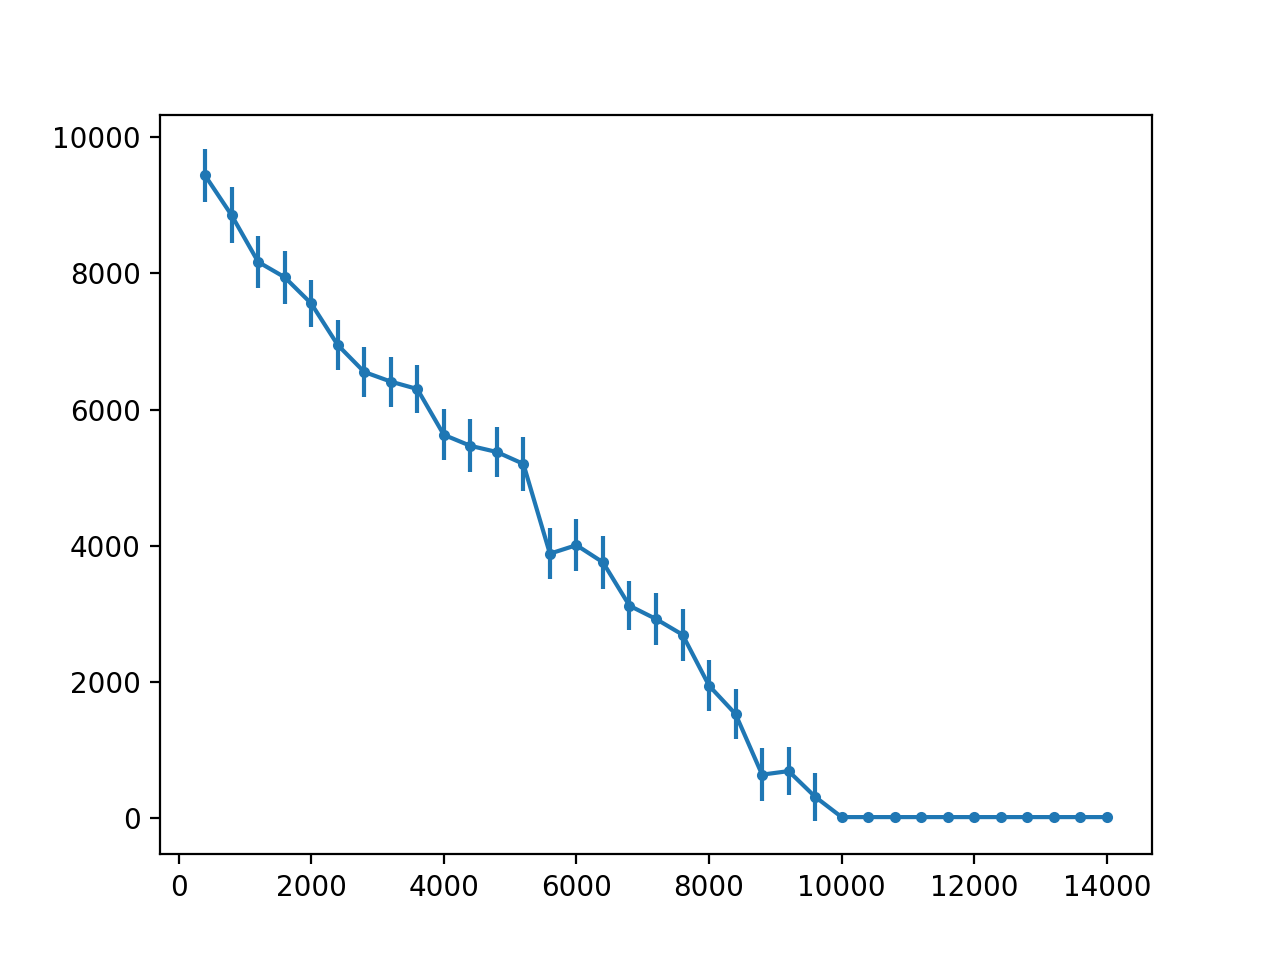

<Container object of 3 artists>

In [52]:
'''
simulate early stopping prediction
input:
    data: the data that used to predict the epoch
    smooth_win_size: window size for smoothing
    epochs_between_eval: number of epochs between two evals
    min_delta, patience: no improvement (less than min_delta) for patience epoch is stopping criteria
    pred_win_size: the window size for epoch prediction, wrt points not real epochs
    left_tail_size: the window where the data should be weighted (< 1) when doing regression, 
                    wrt points not real epochs
    period: the period for prediction, wrt points not real epochs
    start_point: at which point we start the first prediction, wrt points not real epochs
    weights_type: the type of weights
                    linear: the weights are linear from 0-1 within the left_tail_size
                    equal: the weights are 1 within the left_tail_size
    num_samples: how many samples to generate when predicting the epoch by bootstrapping
    upper_limit: only consider the predicted epoch smaller than upper_limit when doing bootstarpping
output:
    preds: predicted epochs
    coeffs: regression coeffients (a,b)
    shifts: the distance that we translation the piece curve to make it close to x-axis
    sample: the sythetic data for each piece curve
    smoothed_sample: smoothing the sythetic data
    CIs: 95% confidence intervals    
'''
def sim_online_early_stopping_prediction_adding_noise(
                                        data, 
                                        smooth_win_size,
                                         epochs_between_eval, 
                                         min_delta, patience, 
                                         pred_win_size, 
                                         left_tail_size, 
                                         period,
                                         start_point=100, 
                                         weights_type='linear',
                                        num_samples=100,
                                        upper_limit=2e4):
    ########################################
    global_step = 0
    ########################################
    # generate weights
    w1_size = pred_win_size - left_tail_size # the number of elements we assign weight 1
    if weights_type == 'linear':
        basic_weights0 = np.linspace(0,1,left_tail_size)
    elif weights_type == 'equal':
        basic_weights0 = np.ones(left_tail_size)
    basic_weights1 = np.ones(w1_size)
    basic_weights = np.concatenate((basic_weights0, basic_weights1))
    def weights_generator(length):
        if length <= w1_size:
            rst = np.ones(length)
        elif length <= pred_win_size:
            s = pred_win_size - length
            rst = basic_weights[s:]
        else:
            z = np.zeros(length - pred_win_size)
            rst = np.concatenate((z, basic_weights))

        return rst
    preds = []
    coeffs = []
    shifts = []
    samples = []
    smoothed_samples = []
    CIs = []
    vars_ = []
    pred = 0
        ########################################
    for i in range(len(data)):
#         print(i)
        global_step += epochs_between_eval
        ########################################
        num_evals = global_step//epochs_between_eval

        if num_evals >= start_point and (num_evals-start_point)%period == 0:
            print(global_step)
            if num_evals < pred_win_size:
                s = 0
            else:
                s = num_evals - pred_win_size
            e = num_evals
            
            # no shift
            x = (np.arange(s,e)+1) * epochs_between_eval
            shift = 0
            # shift the piece of curve 
#             x = (np.arange(0,e-s)+1) * epochs_between_eval
#             shift = s*epochs_between_eval
            y = data[s:e]
            weights = weights_generator(len(y))
            
            a, b = power_regression(x, y, weights)
            var = np.var(y-a*np.power(x,b))
            
            print(a,b,var,min_delta,patience,epochs_between_eval,smooth_win_size,num_samples,upper_limit)
            
            last_pred = pred
            pred, stopping_epochs, sample, smoothed_sample = early_stopping_prediction_adding_noise(
                                                                a,b,var,
                                                                min_delta,patience,
                                                                 epochs_between_eval,
                                                                 smooth_win_size,
                                                                 num_samples=num_samples,
                                                                 upper_limit=upper_limit,
#                                                                  lower_limit=shift-5000
                                                                                 )
            
            _, CI_left, CI_right = mean_confidence_interval(stopping_epochs)
            
            # what if the predicted epoch is smaller than the current epoch
            ## use the previous predicted epoch
            ## if still smaller, use the current epoch
            ## CI is meaningless in this case
            if pred < (e+1) * epochs_between_eval:
                pred = last_pred
                if pred < (e+1) * epochs_between_eval:
                    pred = (e+1) * epochs_between_eval
                CI_left = 0
                CI_right = 0
                
            # we should do this because we shift the curve before
#             pred += s*epochs_between_eval
            preds.append(pred)
            CIs.append((CI_left, CI_right))
            coeffs.append((a,b))
            shifts.append(shift)
            samples.append(sample)
            smoothed_samples.append(smoothed_sample)
            
            
            vars_.append(var)
                        

    return preds, coeffs, shifts, samples, smoothed_samples, CIs, vars_

def CIs2errs(CIs):
    errs = []
    for ci in CIs:
        errs.append((ci[1]-ci[0])/2)
    
    return np.array(errs)


pred_win_size = 1000
left_tail_size = 0
period = 20
start_point = 20
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000

# it's acually equivalent to setting no upper limit because 2e5 is larger enough
upper_limit = 2e5

# set a effective upper limit
upper_limit_bias = 80
upper_limit = (len(val_err) + upper_limit_bias)*num_epochs_between_eval

preds, coeffs, shifts, samples, smoothed_samples, CIs, _ = sim_online_early_stopping_prediction_adding_noise(
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    start_point = start_point,
                                    weights_type = wtype,
                                    num_samples=1000,
                                    upper_limit=upper_limit)
print(len(preds))

errs = CIs2errs(CIs)

plt.figure()
x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval
plt.errorbar(x, preds-x, errs, fmt='.-')

<IPython.core.display.Javascript object>


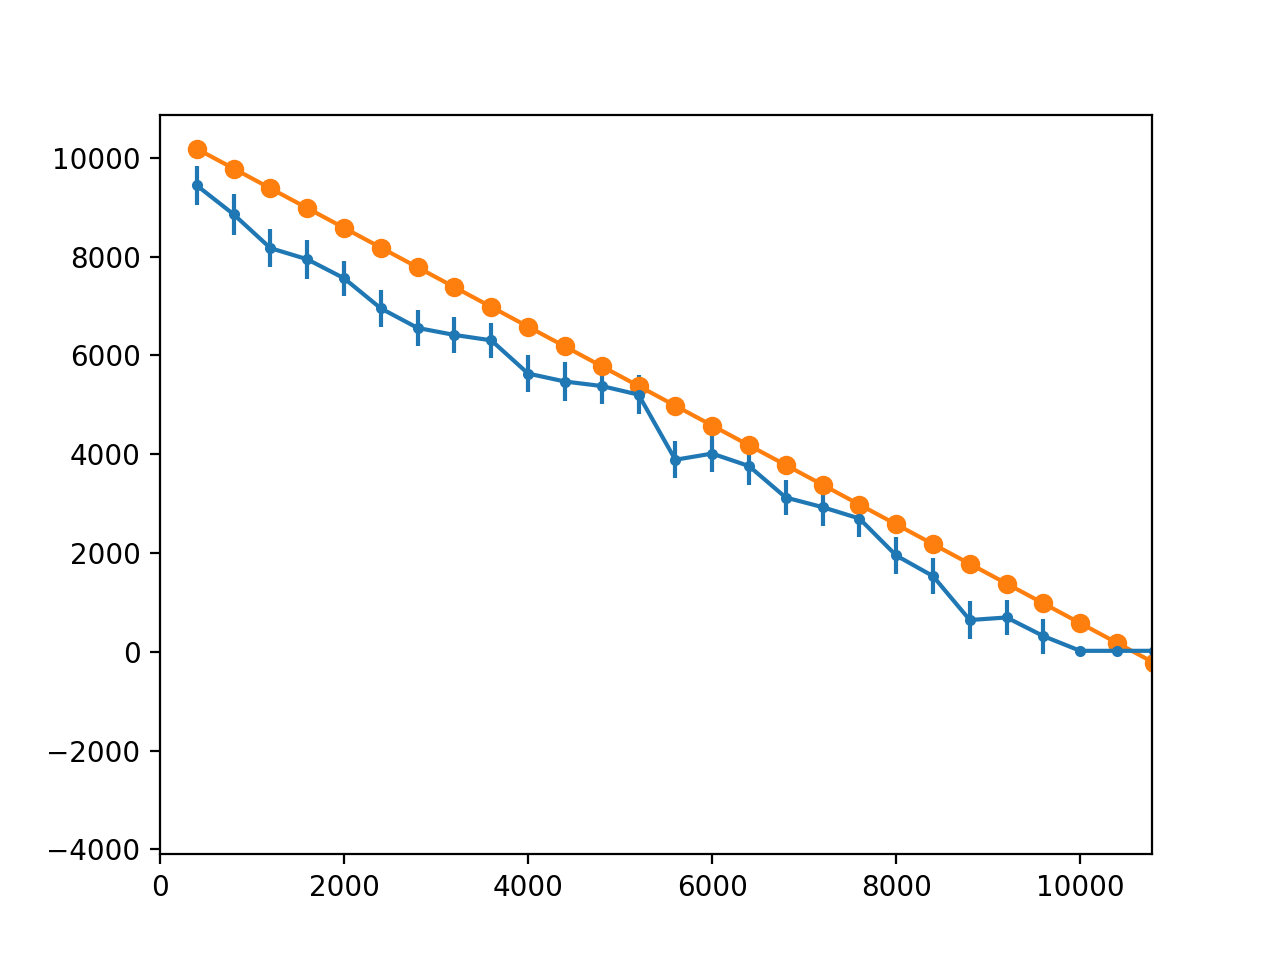

(0, 10780)

In [53]:
plt.figure()
x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval
plt.errorbar(x, preds-x, errs, fmt='.-')
plt.plot(x, earlyStoppingStep-x,'-o')
plt.xlim(0,earlyStoppingStep+200)
# plt.ylim(0,4000)

<IPython.core.display.Javascript object>


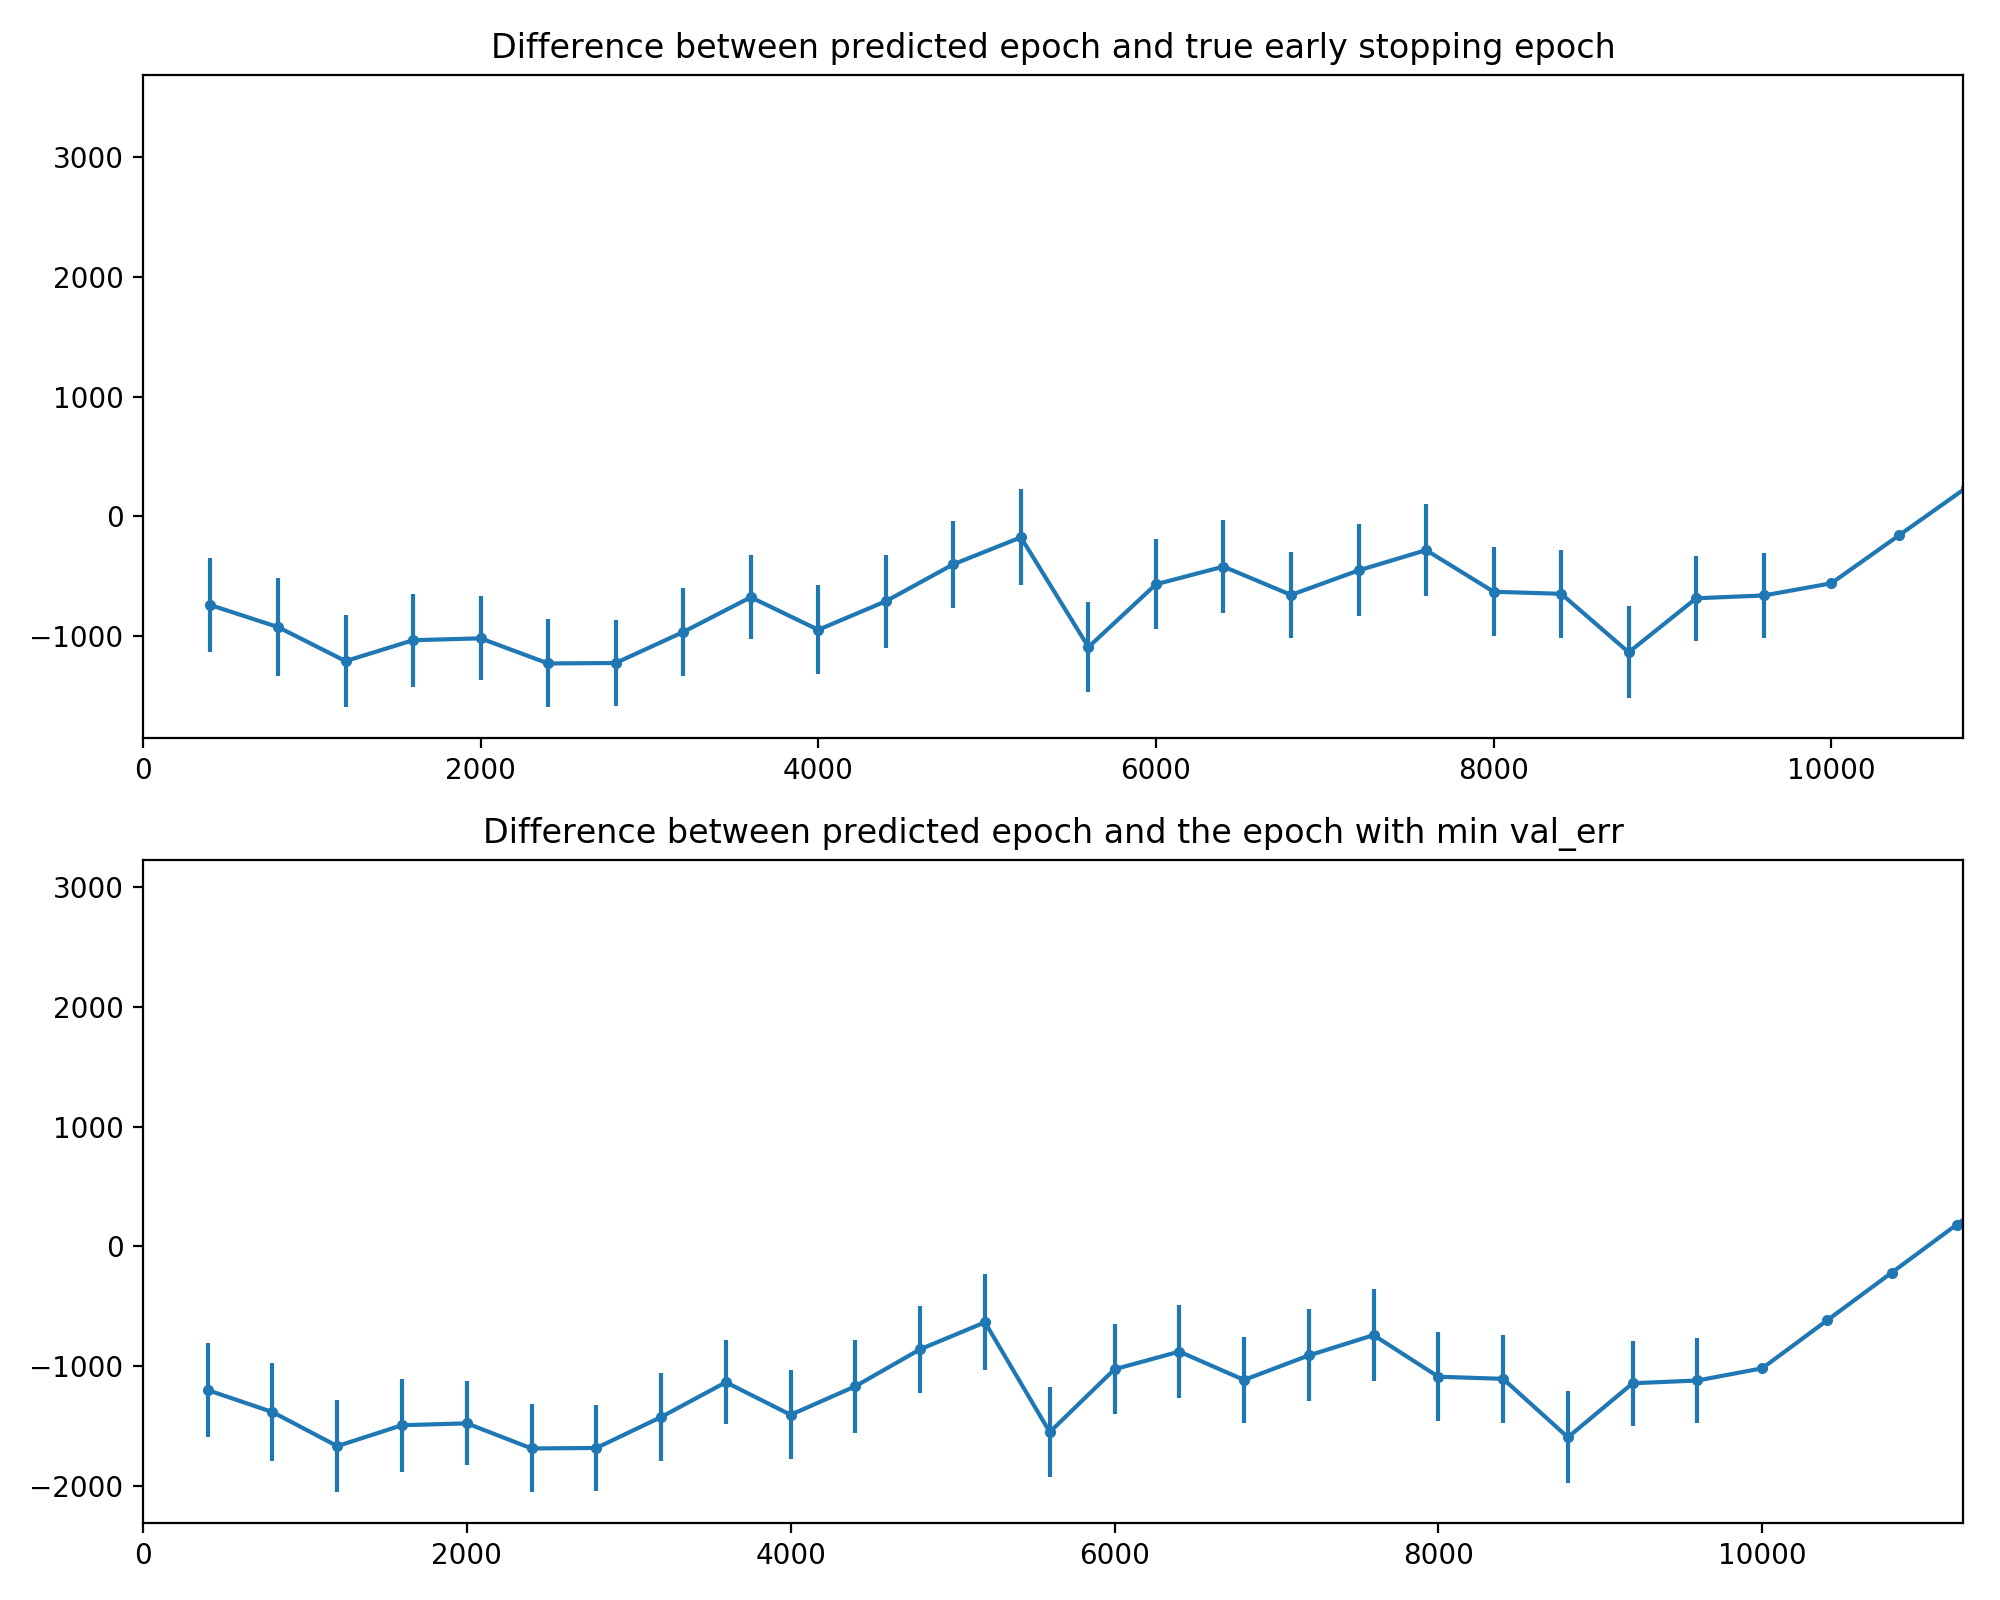

In [55]:
fig = plt.figure(figsize=[10, 8])
x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval

ax = plt.subplot(211)
# ax.set_xlim(7500,10500)
# ax.set_ylim(-2000,2000)
ax.errorbar(x, np.array(preds)-earlyStoppingStep, errs, fmt='.-')
ax.set_xlim(0, earlyStoppingStep+200)
ax.set_title('Difference between predicted epoch and true early stopping epoch')

ax = plt.subplot(212)
# ax.set_xlim(7500,10500)
# ax.set_ylim(-2000,0)
ax.errorbar(x, np.array(preds)-minEpoch, errs, fmt='.-')
ax.set_xlim(0, minEpoch+200)
ax.set_title('Difference between predicted epoch and the epoch with min val_err')

fig.tight_layout()

## Predicted epochs by adding noise are not sensitive to the online predicted window size

<IPython.core.display.Javascript object>


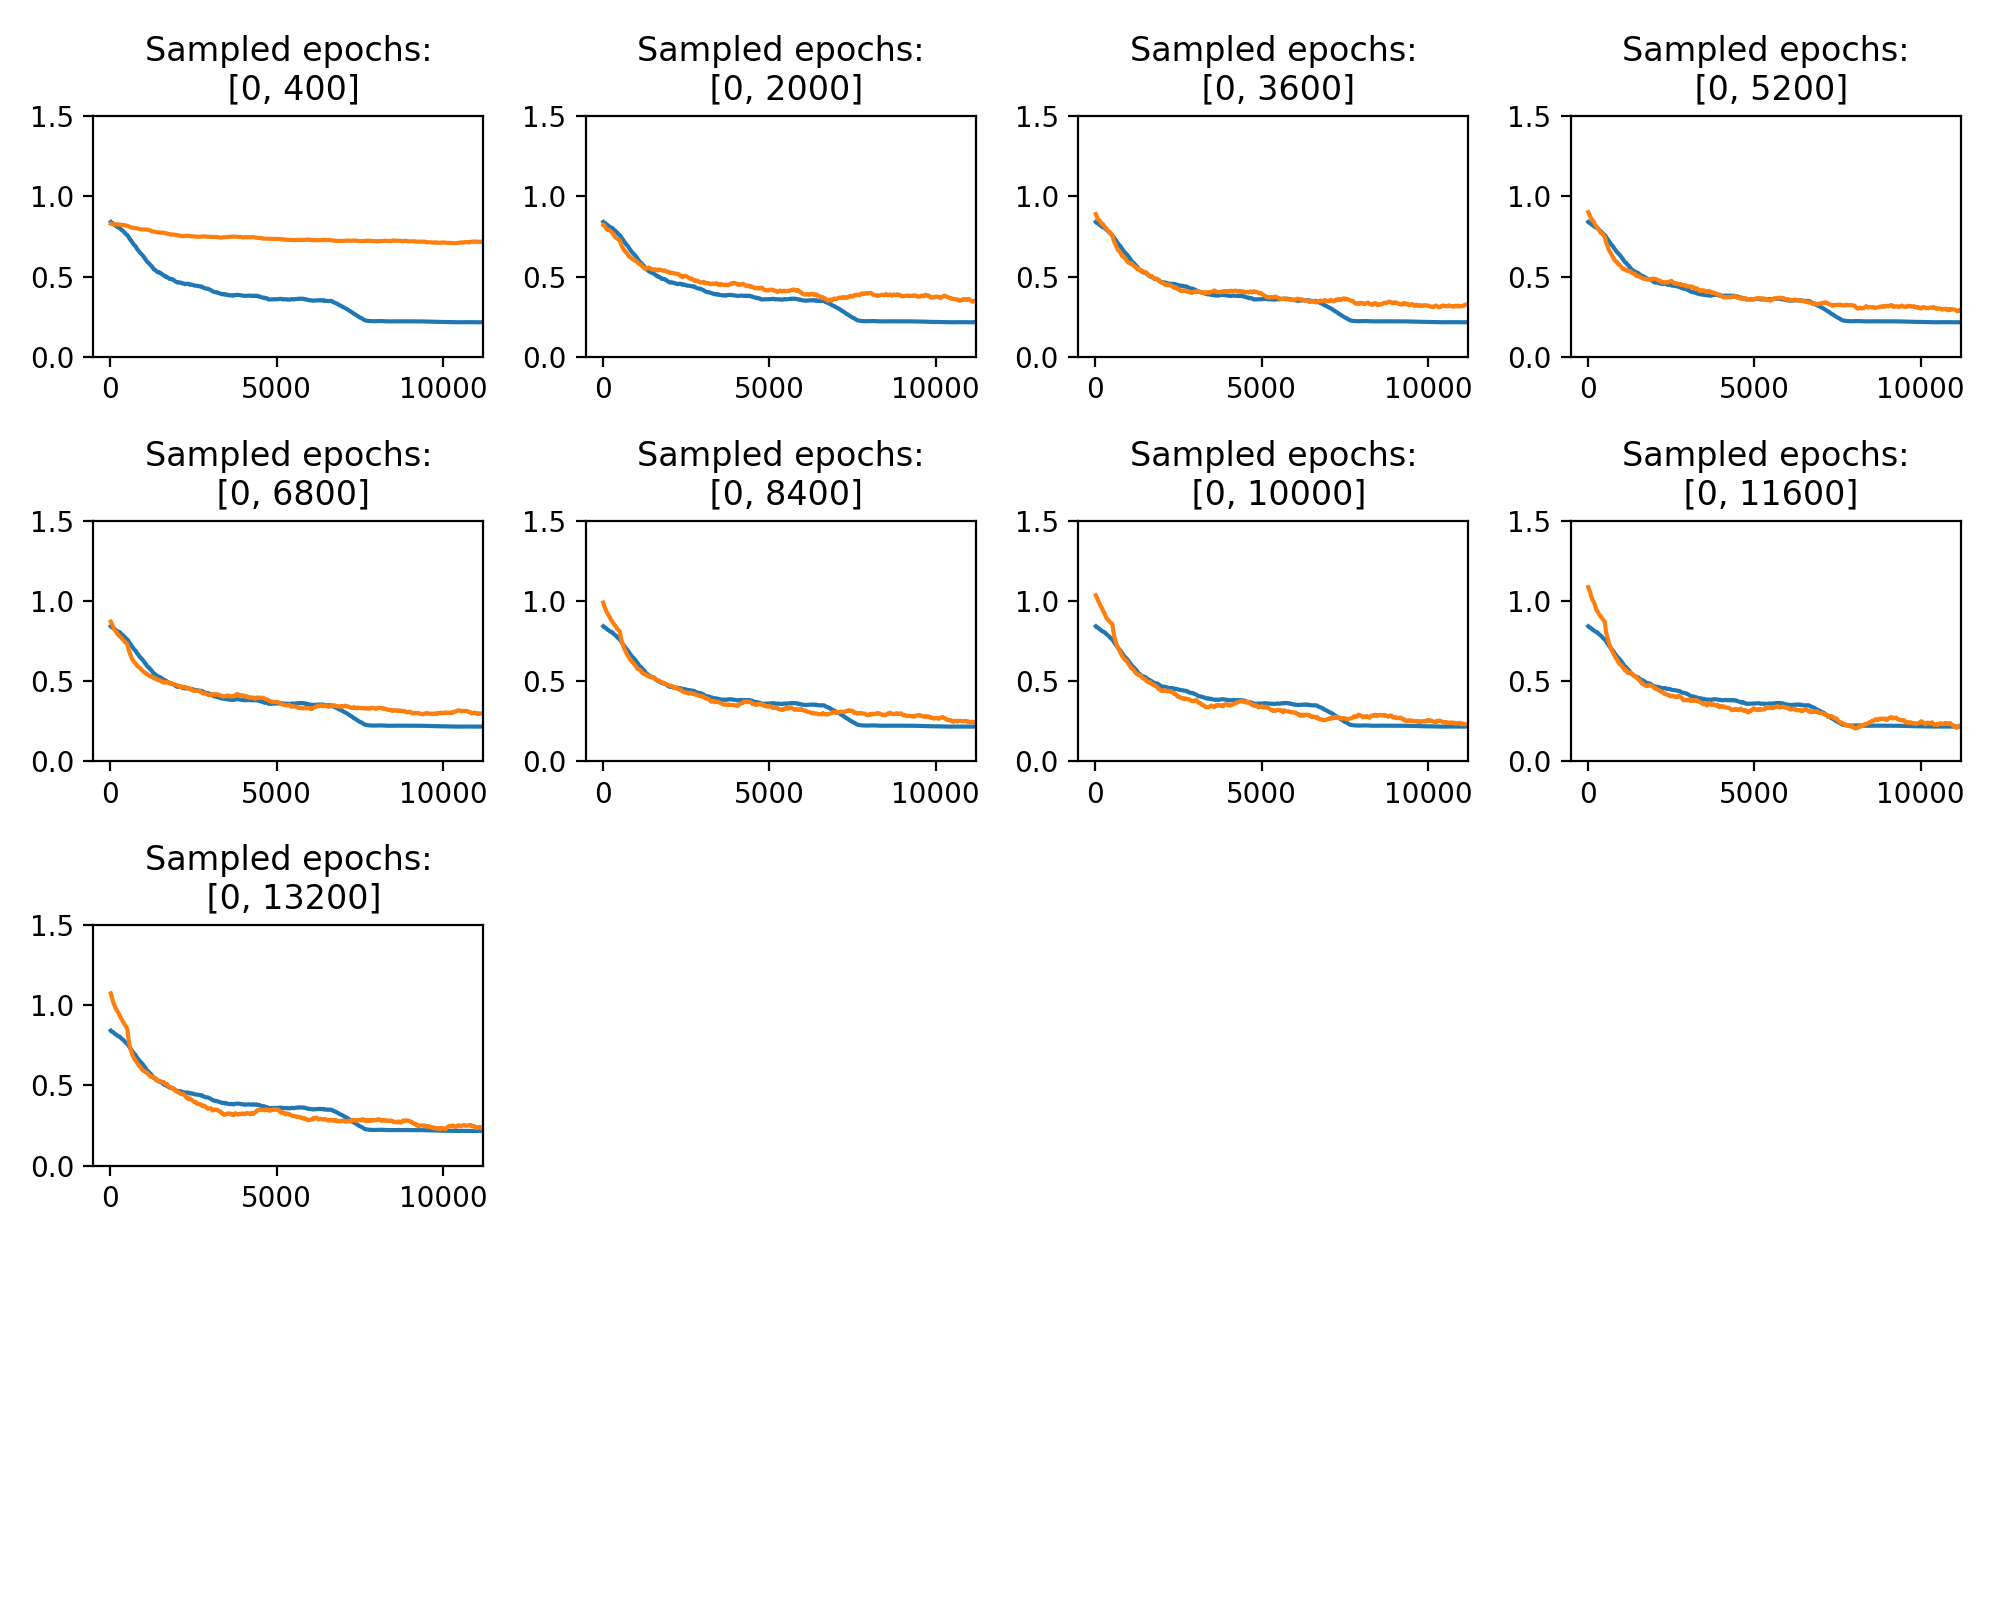

In [54]:
# print(coeffs)
fig = plt.figure(figsize=[10, 8])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)

co = 0
step_size = 4
for i in range(0,len(coeffs),step_size):
    co += 1
    ax = plt.subplot(4,4, co)
    ax.set_ylim(0, 1.5)
#     ax.plot(steps, val_err)
    ax.plot(steps[:len(smoothed_val_err)], smoothed_val_err)
    x = np.arange(1,len(smoothed_samples[i])+1)*num_epochs_between_eval
#     ax.plot(x,smoothed_samples[i])
    ax.plot(x+shifts[i],smoothed_samples[i])
#     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + i*period)*num_epochs_between_eval
    s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,11200)
    
fig.tight_layout()   